# Описание проекта
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

# Цели:

- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Описание данных
Имеются следующие данные с признаками:

*id* — уникальный идентификатор сотрудника;

*dept* — отдел, в котором работает сотрудник;

*level* — уровень занимаемой должности;

*workload* — уровень загруженности сотрудника;

*employment_years* — длительность работы в компании (в годах);

*last_year_promo* — показывает, было ли повышение за последний год;

*last_year_violations* — показывает, нарушал ли сотрудник трудовой договор за последний год;

*supervisor_evaluation* — оценка качества работы сотрудника, которую дал руководитель;

*salary* — ежемесячная зарплата сотрудника;

*job_satisfaction_rate* — уровень удовлетворённости сотрудника работой в компании, целевой признак.


В нашем распоряжении датасеты для 2-х задач:

1. **Для первой модели:** 

Тренировочная выборка: *train_job_satisfaction_rate.csv*;

Входные признаки тестовой выборки: *test_features.csv*;

Целевой признак тестовой выборки: *test_target_job_satisfaction_rate.csv*.

2. **Для второй модели:**

Тренировочная выборка: *train_quit.csv*;

Входные признаки тестовой выборки те же, что и в прошлой задаче: *test_features.csv*;

Целевой признак тестовой выборки: *test_target_quit.csv*.


In [1]:
!pip install -Uq scikit-learn
!pip install phik

In [2]:
#Импорт библиотек, классов, моделей
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer,classification_report
from phik import phik_matrix, report
from phik.report import plot_correlation_matrix

RANDOM_STATE = 42
TEST_SIZE = 0.25

## ЗАДАЧА 

### ЗАГРУЗКА ДАННЫХ

In [3]:
job_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal='.', sep=',')
test_features = pd.read_csv('/datasets/test_features.csv', decimal='.', sep=',')
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal='.', sep=',') 

In [4]:
display(job_satisfaction.head(),  
        job_satisfaction.describe(), 
        job_satisfaction.shape)
display(job_satisfaction.duplicated().sum(),
        job_satisfaction.isna().sum())
job_satisfaction.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


(4000, 10)

0

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [5]:
display(test_features.head(),  
        test_features.describe(), 
        test_features.shape)
display(test_features.duplicated().sum(),
        test_features.isna().sum())
        
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


(2000, 9)

0

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [6]:
display(test_target.head(),  
        test_target.describe(), 
        test_target.shape)
display(test_target.duplicated().sum(),
        test_target.isna().sum())

test_target.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


(2000, 2)

0

id                       0
job_satisfaction_rate    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Промежуточный вывод:** после загрузки данных и "беглого" анализа выяснили что с данными в целом всё в порядке. Названия столбцов соответствуют "змеиному" регистру, типы данных в норме, отсутствуют явные дубликаты. Единственное - имеются пропуски, их немного.

### ПРЕДОБРАБОТКА ДАННЫХ

In [7]:
#Посмотрим на наличие неявных дубликатов
print(job_satisfaction['dept'].unique(),
      job_satisfaction['level'].unique(),
      job_satisfaction['workload'].unique(),
      job_satisfaction['last_year_promo'].unique(),
      job_satisfaction['last_year_violations'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] ['junior' 'middle' 'sinior' nan] ['medium' 'high' 'low'] ['no' 'yes'] ['no' 'yes']


In [8]:
print(test_features['dept'].unique(),
      test_features['level'].unique(),
      test_features['workload'].unique(),
      test_features['last_year_promo'].unique(),
      test_features['last_year_violations'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] ['junior' 'middle' 'sinior' nan] ['medium' 'low' 'high' ' '] ['no' 'yes'] ['no' 'yes']


**Вывод по предобработке данных:** пустые значения заменим на nan в дальнейших этапах. В целом данные в норме.

### ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

**job_satisfaction**

In [10]:
#Список с числовыми переменными
num_col=['salary', 'job_satisfaction_rate']
#Список с названиями графиков
titles_num = ['ежемесячная зарплата', 'уровень удовлетворённости']

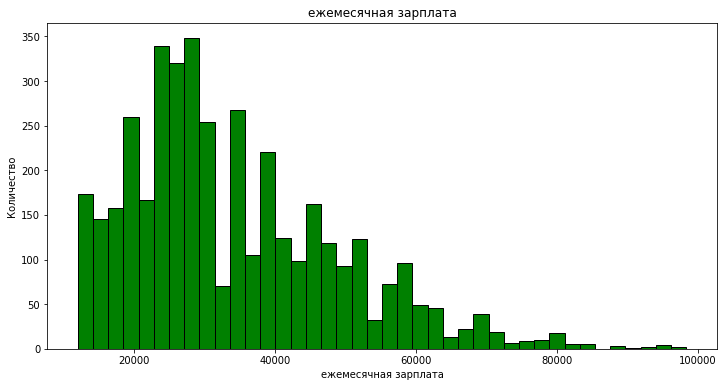

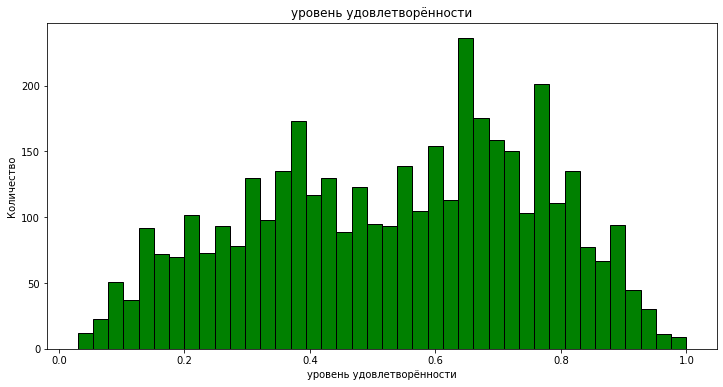

In [11]:
#Построим гистограммы
for i in range(len(num_col)):
    plt.figure(figsize=(12, 6))
    plt.hist(job_satisfaction[num_col[i]], color = 'green', edgecolor = 'black', bins = 40)
    plt.title(titles_num[i])
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()

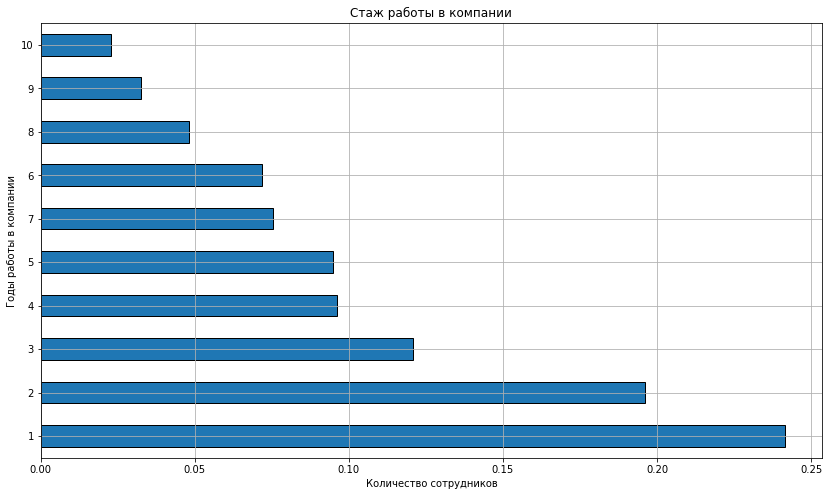

In [12]:
job_satisfaction['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Стаж работы в компании')
plt.xlabel('Количество сотрудников')
plt.ylabel('Годы работы в компании')
plt.show()

В основном трудятся в компании от 1 до 6 лет. В среднем рабочей стаж 3 года.

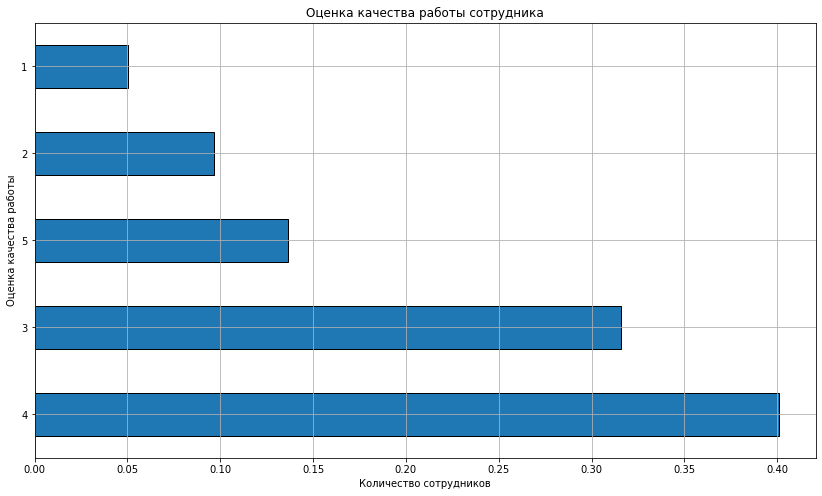

In [13]:
job_satisfaction['supervisor_evaluation'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы')
plt.show()

Больше всего оценок качества работы сотрудников приходятся на 3 и 4 балла. Есть и те у кого оценка 1, кандидат на увольнение?

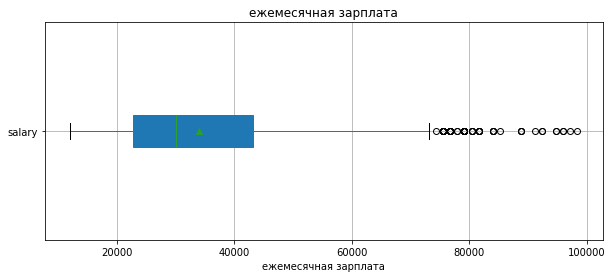

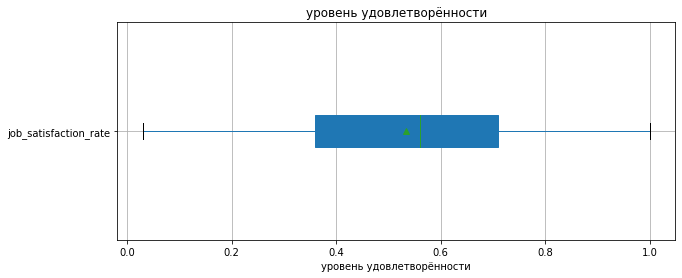

In [14]:
for i in range(len(num_col)):
    plt.figure(figsize=(10, 4))
    job_satisfaction.boxplot(num_col[i], patch_artist=True, vert=False, showmeans=True )
    plt.title(titles_num[i])
    plt.xlabel(titles_num[i])
    plt.show()

Средняя зарплата не намного больше медианной, при учете нескольких выбросов, и равна 33926,70 тыс. руб. Максимальная 98400 тыс. руб., а минимальная — 12000 тыс. руб.
Удовлетворенность сотрудника работой соответствует оценке качества. 

In [15]:
#Список с категориальными переменными
cat_col=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
#Список с названиями графиков 
titles_cat_col= ['Отдел сотрудника', 
                 'Уровень занимаемой должности', 
                 'Уровень загруженности', 
                 'Повышение за последний год', 
                 'Нарушения сотрудником трудового договора за последний год']

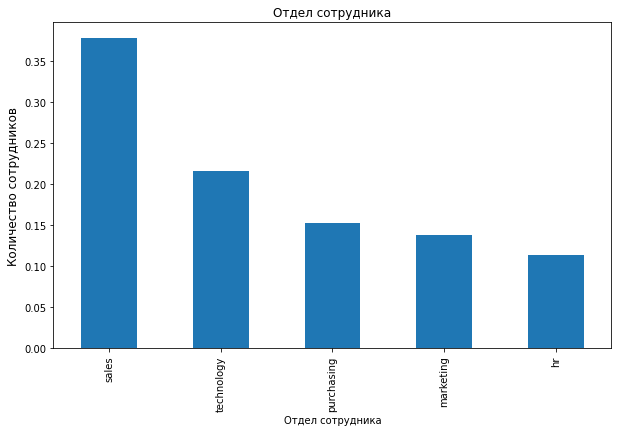

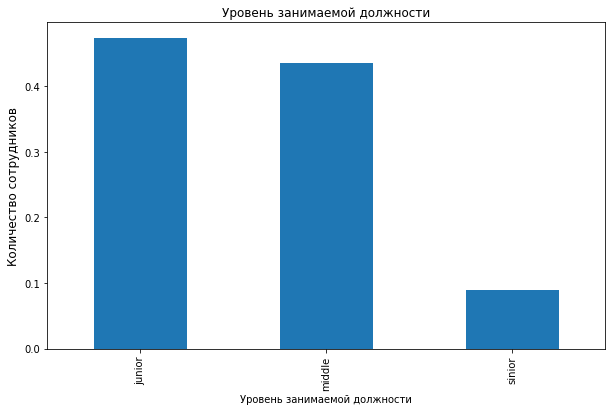

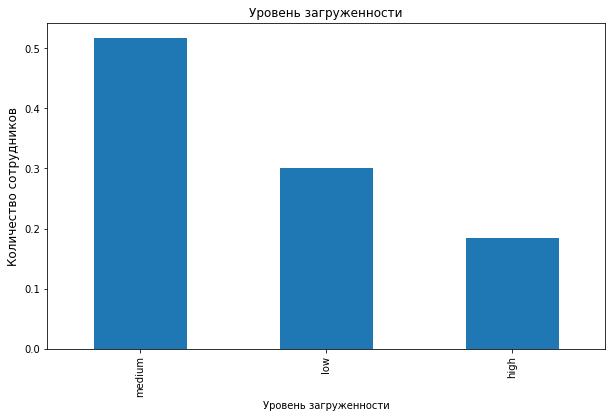

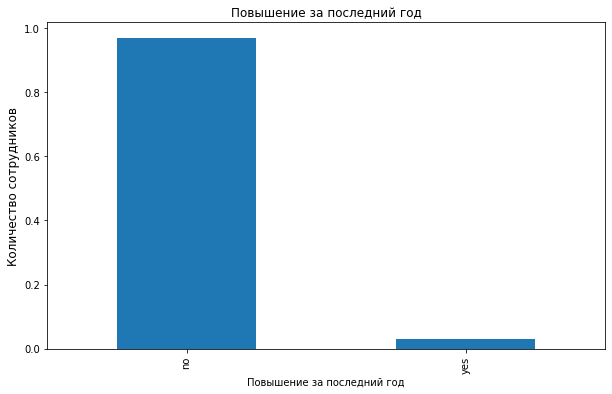

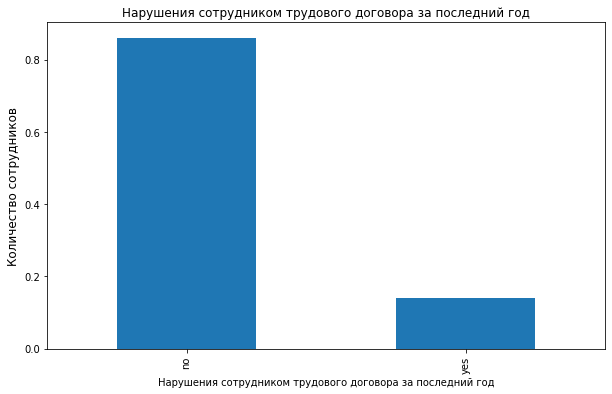

In [16]:
for i in range(len(cat_col)):
    plt.figure(figsize=(10, 6))
    job_satisfaction[cat_col[i]].value_counts(normalize=True).plot.bar()
    plt.title(titles_cat_col[i])
    plt.ylabel('Количество сотрудников', size=12)
    plt.xlabel(titles_cat_col[i]) 
    plt.show()

Краткий вывод по категориальным данным:

- Преимущественное количество сотрудников работают в отделе *sales*, за ними следуют отдел *technology*.

- по уровню занимаемой должности, основное число сотрудников это junior, а за ним не отстает middle;

- по загруженности персонала видим что в основном это средний уровень, много и  низко загруженных сотрудников;

- в компании за последний год почти не было повышения, вероятно из-за среднего стажа в 3 года;

- по нарушениям отметим низкий уровень нарушений трудового договора, но не без греха. 

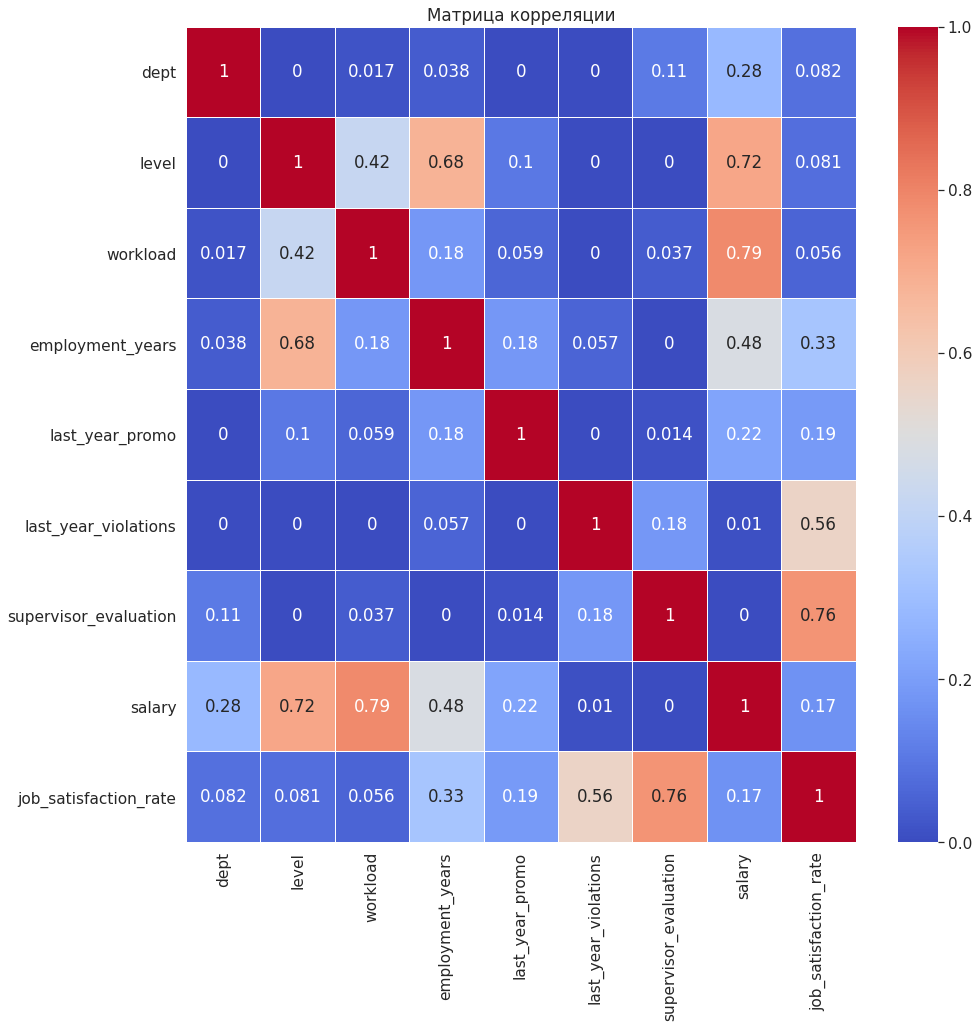

In [17]:
#Матрица корреляции
job_satisfaction_1=job_satisfaction.drop(['id'], axis=1)
corr_matrix = job_satisfaction_1.phik_matrix(interval_cols = num_col)
sns.set(font_scale=1.4)
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Мультиколлинеарности не наблюдается. Высокие уровни зависимости между: зарплатой и уровнем занимаемой должности, зарплатой и уровнем загруженности, оценкой качества работы сотрудника и уровнем удовлетворенности сотрудника работой. 

**test_features**

In [18]:
#Список с числовыми переменными
num_col_1=['salary']
#Список с названиями графиков
titles_num_1 = ['ежемесячная зарплата']

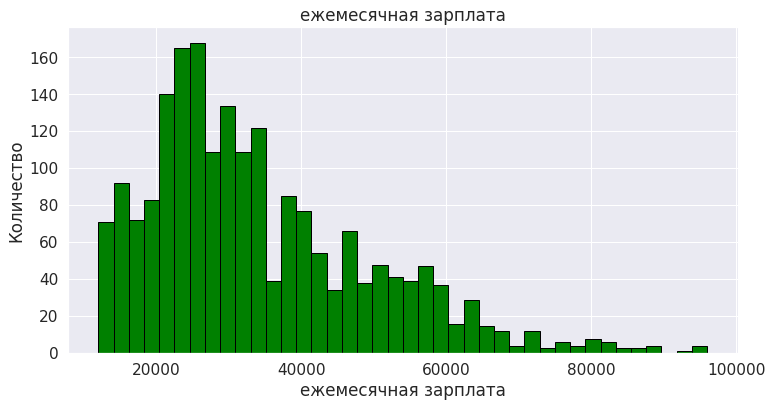

In [19]:
#Построим гистограммы
for i in range(len(num_col_1)):
    plt.figure(figsize=(12, 6))
    plt.hist(test_features[num_col_1[i]], color = 'green', edgecolor = 'black', bins = 40)
    plt.title(titles_num_1[i])
    plt.ylabel("Количество")
    plt.xlabel(titles_num_1[i])
    plt.show()

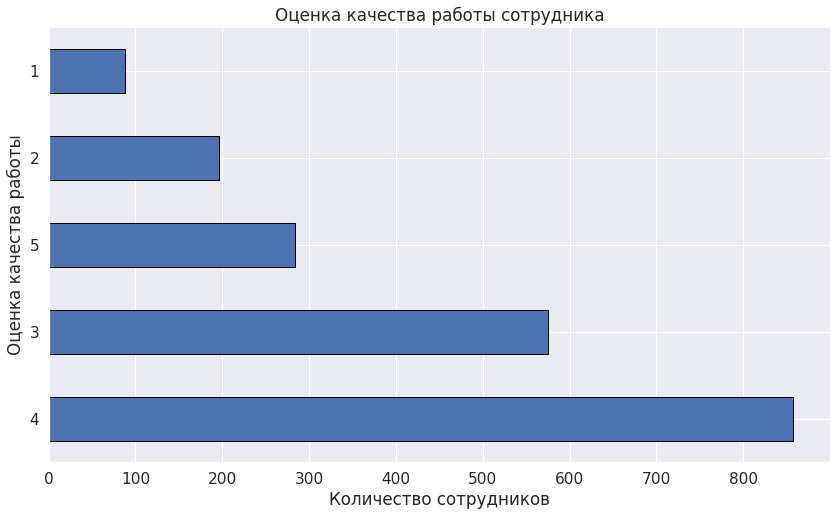

In [20]:
test_features['supervisor_evaluation'].value_counts().plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы')
plt.show()

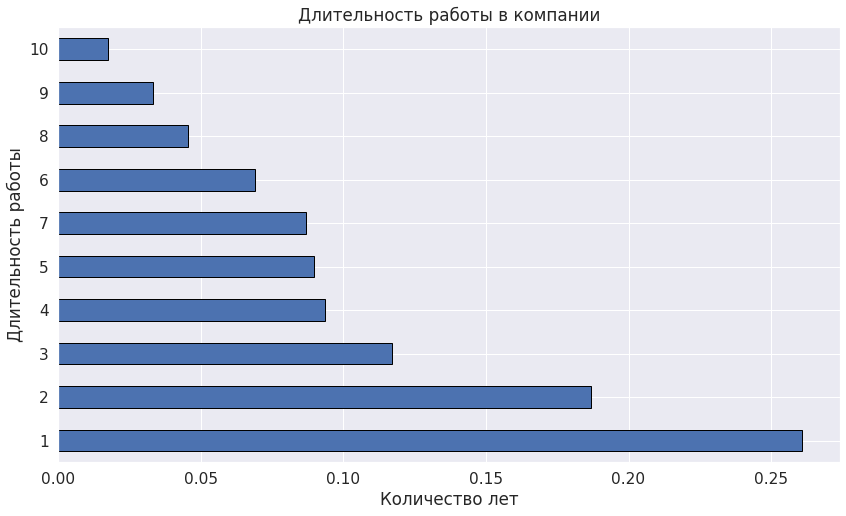

In [21]:
test_features['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Длительность работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Длительность работы')
plt.show()

In [22]:
#Список с категориальными переменными
cat_col_1=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
#Список с названиями графиков 
titles_cat_col_1= ['Отдел сотрудника', 
                   'Уровень занимаемой должности', 
                   'Уровень загруженности сотрудника', 
                   'Повышение за последний год', 
                   'Нарушения сотрудником трудового договора за последний год']

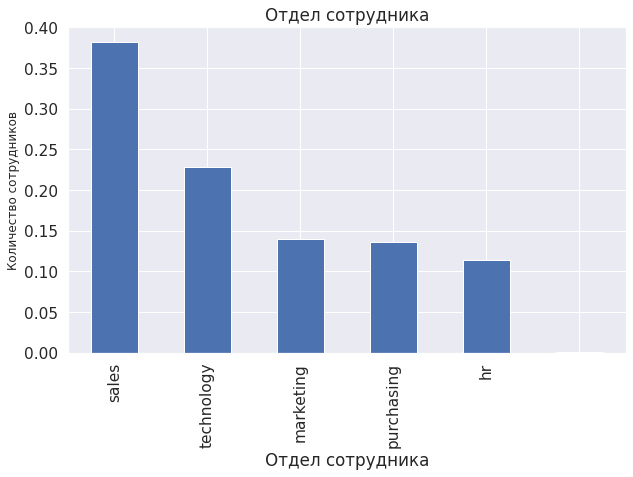

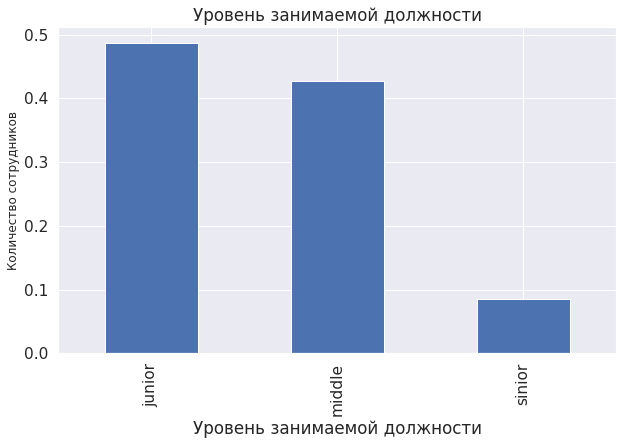

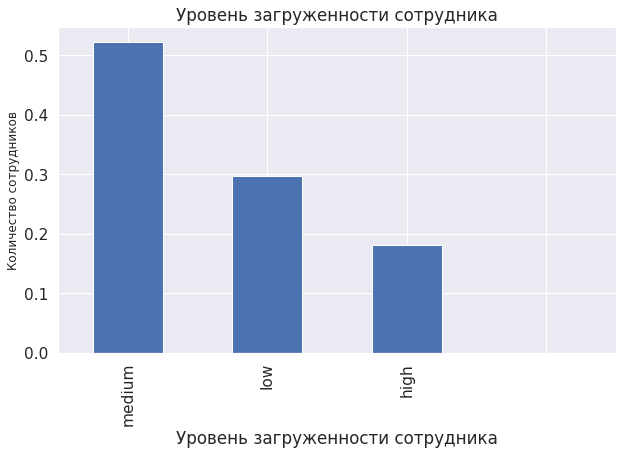

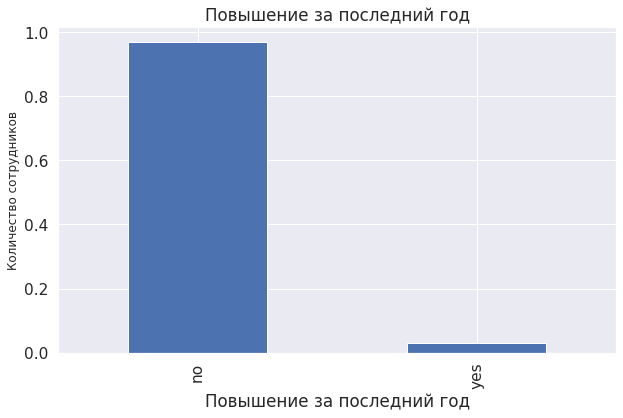

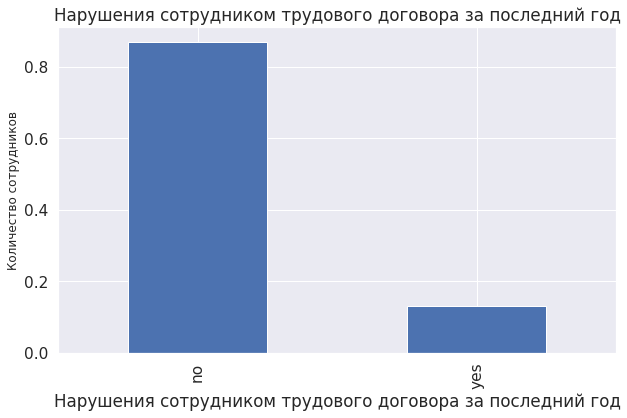

In [23]:
for i in range(len(cat_col)):
    plt.figure(figsize=(10, 6))
    test_features[cat_col_1[i]].value_counts(normalize=True).plot.bar()
    plt.title(titles_cat_col_1[i])
    plt.xlabel(titles_cat_col_1[i])
    plt.ylabel('Количество сотрудников', size=12)
    plt.show()

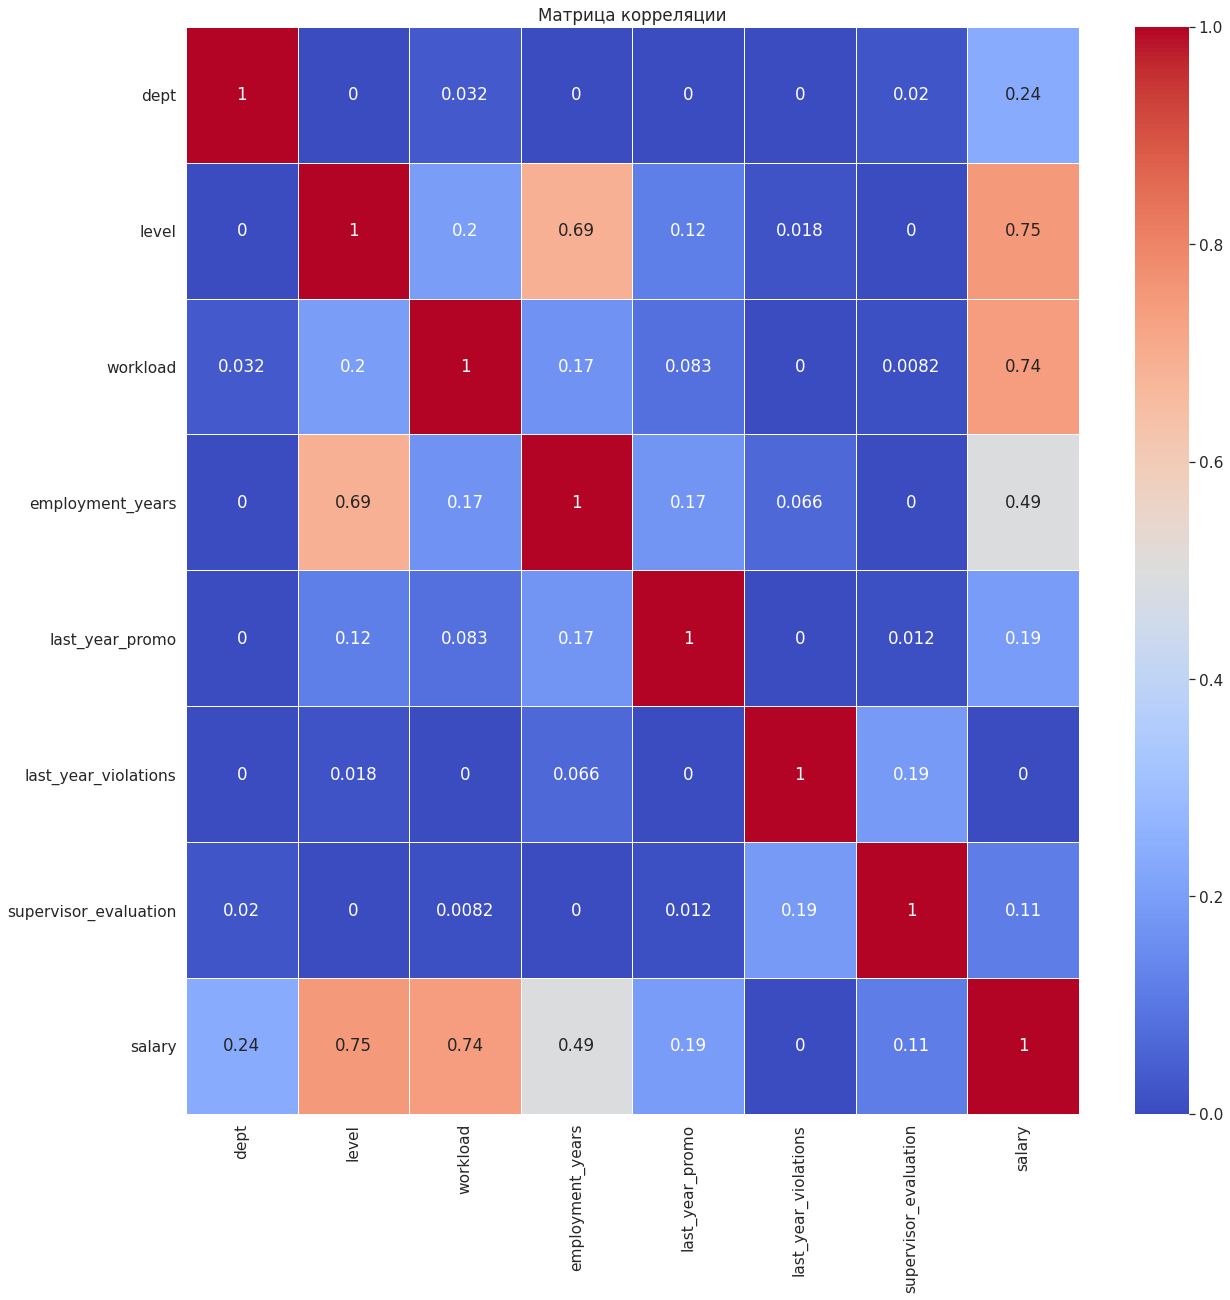

In [24]:
test_features_1=test_features.drop(['id'], axis=1)
corr_matrix = test_features_1.phik_matrix (interval_cols = num_col)
sns.set(font_scale=1.4)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Входные признаки тестовой выборки ничем "не зацепили".

**Вывод по исследовательскому анализу данных:**

По *job_satisfaction*:

- В основном трудятся в компании от 1 до 6 лет. В среднем рабочей стаж 3 года. 

- Больше всего оценок качества работы сотрудников приходятся на 3 и 4 балла. Есть и те у кого оценка 1.

- Средняя зарплата не намного больше медианной, при учете нескольких выбросов, и равна 33926,70 тыс. руб. Максимальная 98400 тыс. руб., а минимальная — 12000 тыс. руб. Удовлетворенность сотрудника работой соответствует оценке качества.

Преимущественное количество сотрудников работают в отделе sales, за ними следуют отдел technology.

по уровню занимаемой должности, основное число сотрудников это junior, а за ним не отстает middle;

по загруженности персонала видим что в основном это средний уровень, много и низко загруженных сотрудников;

в компании за последний год почти не было повышения, вероятно из-за среднего стажа в 3 года;

по нарушениям отметим низкий уровень нарушений трудового договора, но не без греха.

Мультиколлинеарности не наблюдается. Высокие уровни зависимости между: зарплатой и уровнем занимаемой должности, зарплатой и уровнем загруженности, оценкой качества работы сотрудника и уровнем удовлетворенности сотрудника работой.

По *test_features*:

Входные признаки тестовой выборки ничем "не зацепили".

### ПОДГОТОВКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛЕЙ

In [25]:
train_1 = job_satisfaction.drop(['id'], axis=1)
train_1.drop_duplicates(inplace=True)

In [26]:
X_train = train_1.drop('job_satisfaction_rate', axis=1)
y_train = train_1['job_satisfaction_rate'] 


ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'] ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)], 
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())])
 
param_grid = [
    {'models': [LinearRegression()],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 21),
     'models__min_samples_split': range(2, 21),
     'models__max_features': range(2, 21),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]


def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


smape_scorer = make_scorer(score_func=smape, greater_is_better=False)
 
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=10,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1)

# обучим лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

#Лучшая модель
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [27]:
test_features = test_features.merge(test_target, on='id', how='left')
X_test = test_features.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_features['job_satisfaction_rate']
best_model = r_search.best_estimator_
print(f'SMAPE лучшей модели по кросс-валидации на обучающих данных: {round(r_search.best_score_*(-1),2)}')
print(f'SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),2)}')

SMAPE лучшей модели по кросс-валидации на обучающих данных: 15.2
SMAPE лучшей модели на тестовой выборке: 13.67


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [28]:
results_dataframe = pd.DataFrame(r_search.cv_results_)
pd.set_option('display.max_colwidth', None)
display(results_dataframe)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025731,0.000903,0.008281,0.000160,StandardScaler(),3,13,16,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__max_features': 13, 'models__max_depth': 16, 'models': DecisionTreeRegressor(random_state=42)}",-15.417466,-14.983604,-16.490462,-16.118751,-15.338537,-15.669764,0.551238,3
1,0.017205,0.000402,0.007148,0.000585,passthrough,2,17,2,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 2, 'models__max_features': 17, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=42)}",-24.872716,-23.563314,-24.481130,-23.984685,-22.923678,-23.965105,0.683583,10
2,0.018269,0.000562,0.006798,0.000126,passthrough,11,20,6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 11, 'models__max_features': 20, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}",-19.170900,-17.929063,-20.001767,-19.643041,-19.344325,-19.217819,0.703489,7
3,0.019300,0.000173,0.007799,0.000186,StandardScaler(),18,2,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 18, 'models__max_features': 2, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}",-20.350672,-18.216274,-19.123693,-20.658752,-19.190411,-19.507960,0.888981,8
4,0.021743,0.000239,0.007834,0.000090,MinMaxScaler(),19,9,12,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 19, 'models__max_features': 9, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}",-15.704430,-15.120440,-16.220630,-16.013916,-15.390329,-15.689949,0.400225,4
5,0.022090,0.001674,0.008255,0.000848,MinMaxScaler(),18,16,7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 18, 'models__max_features': 16, 'models__max_depth': 7, 'models': DecisionTreeRegressor(random_state=42)}",-18.538125,-17.185191,-19.145122,-18.988599,-18.633586,-18.498124,0.693241,6
6,0.021055,0.000419,0.006872,0.000152,passthrough,12,12,17,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 12, 'models__max_features': 12, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}",-15.092701,-14.793417,-15.749229,-15.821695,-14.550974,-15.201603,0.507189,1
7,0.018773,0.000279,0.007692,0.000152,MinMaxScaler(),13,3,6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 13, 'models__max_features': 3, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}",-21.775863,-20.153624,-22.963756,-21.496472,-20.766716,-21.431286,0.953469,9
8,0.018878,0.000160,0.007190,0.000572,passthrough,20,7,15,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 20, 'models__max_features': 7, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}",-15.669428,-15.368294,-16.311025,-16.938128,-15.541134,-15.965602,0.581342,5
9,0.020771,0.000439,0.006876,0.000199,passthrough,7,11,12,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 7, 'models__max_features': 11, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}",-15.430203,-14.200695,-16.222047,-16.294226,-14.637269,-15.356888,0.835118,2


**Вывод по подготовке данных и обучению моделей:**

Для поиска лучшей модели:

- была проведена подготовка данных;
- в качестве моделей рассматривались DecisionTreeRegressor() и LinearRegression();
- для модели DecisionTreeRegressor был подобраны гиперпараметры;
- для перебора моделей и параметров использовали метод RandomizedSearchCV;
- в качестве метрики оценки модели была определена метрика smape.
    
Лучшей моделью оказалась:

DecisionTreeRegressor(max_depth=17, max_features=12, random_state=42)

Метрика лучшей модели на тренировочной выборке: 15.2

Значение метрики SMAPE на тестовых данных: 13.67.    

## ЗАДАЧА

### ЗАГРУЗКА ДАННЫХ

In [29]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [30]:
display(train_quit.head(),  
        train_quit.describe(), 
        train_quit.shape)
display(train_quit.duplicated().sum(),
        train_quit.isna().sum())
train_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


(4000, 10)

0

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [31]:
display(test_features.head(),  
        test_features.describe(), 
        test_features.shape)
display(test_features.duplicated().sum(),
        test_features.isna().sum())
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


(2000, 9)

0

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [32]:
display(test_target_quit.head(),  
        test_target_quit.describe(), 
        test_target_quit.shape)
display(test_target_quit.duplicated().sum(),
        test_target_quit.isna().sum())
test_target_quit.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


(2000, 2)

0

id      0
quit    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Промежуточный вывод:** после загрузки данных и "беглого" анализа выяснили что с данными в целом всё в порядке. Названия столбцов соответствуют "змеиному" регистру, типы данных в норме, отсутствуют явные дубликаты. Единственное - имеются пропуски, их немного.

### ПРЕДОБРАБОТКА ДАННЫХ

In [33]:
#Посмотрим на наличие неявных дубликатов
print(train_quit['dept'].unique(),
      train_quit['level'].unique(),
      train_quit['workload'].unique(),
      train_quit['employment_years'].unique(),
      train_quit['last_year_promo'].unique(),
      train_quit['last_year_violations'].unique(),
      train_quit['supervisor_evaluation'].unique(),
      train_quit['salary'].unique(),
      train_quit['quit'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr'] ['middle' 'junior' 'sinior'] ['high' 'medium' 'low'] [ 2  5  1  8  4  7  3  9  6 10] ['no' 'yes'] ['no' 'yes'] [4 1 3 5 2] [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400] ['no' 'yes']


In [34]:
print(test_features['dept'].unique(),
      test_features['level'].unique(),
      test_features['workload'].unique(),
      test_features['employment_years'].unique(),
      test_features['last_year_promo'].unique(),
      test_features['last_year_violations'].unique(),
      test_features['supervisor_evaluation'].unique(),
      test_features['salary'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] ['junior' 'middle' 'sinior' nan] ['medium' 'low' 'high' ' '] [ 2  1  5  6  3  9  7  4  8 10] ['no' 'yes'] ['no' 'yes'] [5 4 3 1 2] [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


**Вывод по предобработке данных:** пустые значения заменим на nan в дальнейших этапах. В целом данные в норме.

### ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

In [36]:
#Список с числовыми переменными
num_col_2=['salary']
#Список с названиями графиков
titles_num_2 = ['ежемесячная зарплата сотрудника']

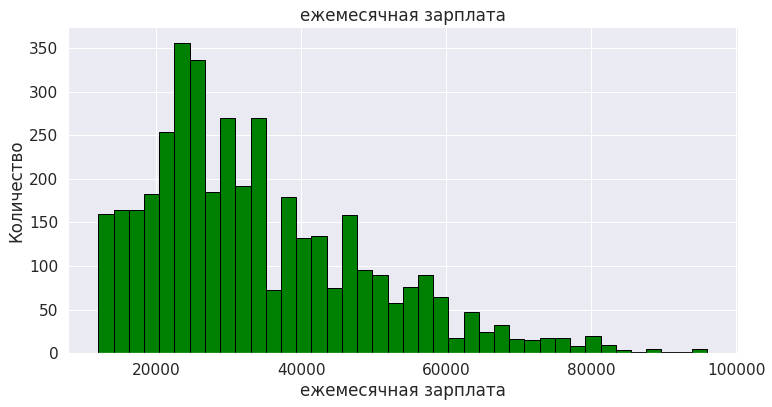

In [37]:
#Построим гистограммы
for i in range(len(num_col_2)):
    plt.figure(figsize=(12, 6))
    plt.hist(train_quit[num_col_2[i]], color = 'green', edgecolor = 'black', bins = 40)
    plt.title(titles_num[i])
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()

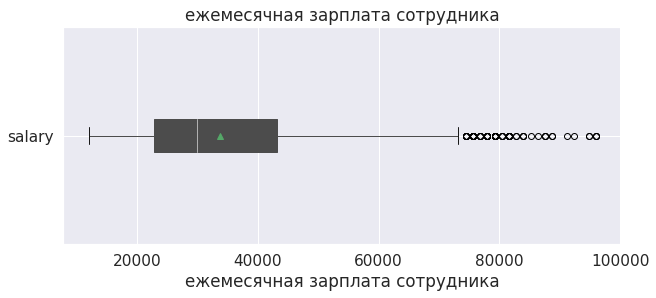

In [38]:
for i in range(len(num_col_2)):
    plt.figure(figsize=(10, 4))
    train_quit.boxplot(num_col_2[i], patch_artist=True, vert=False, showmeans=True )
    plt.title(titles_num_2[i])
    plt.xlabel(titles_num_2[i])
    plt.show();

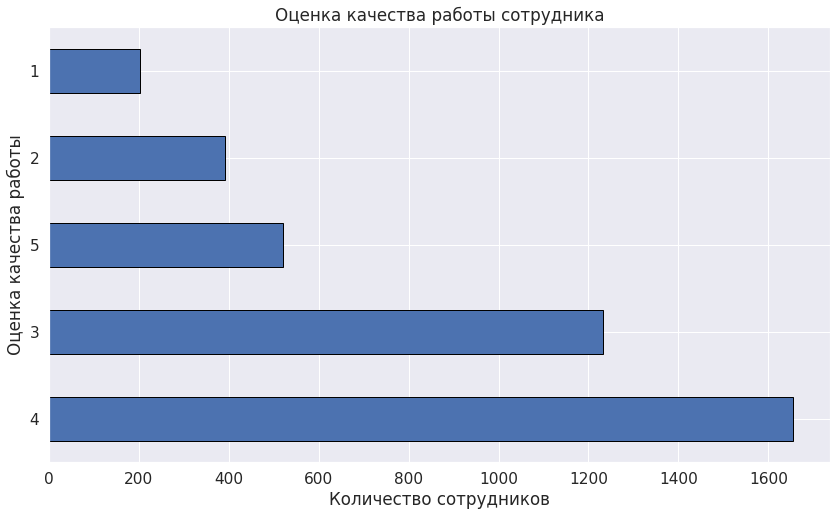

In [39]:
train_quit['supervisor_evaluation'].value_counts().plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы')
plt.show()

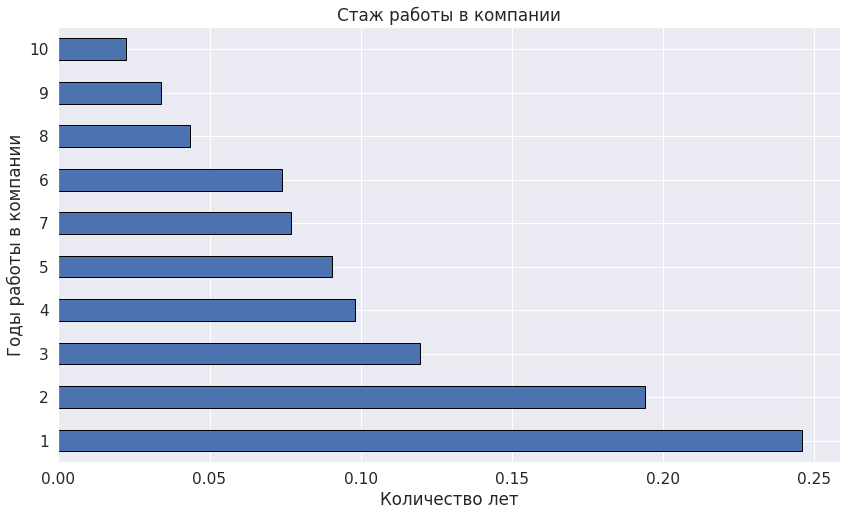

In [40]:
train_quit['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Стаж работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Годы работы в компании')
plt.show()

In [41]:
#Список с категориальными переменными
cat_col_2=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
#Список с названиями графиков 
titles_cat_col_2= ['Отдел сотрудника', 
                   'Уровень занимаемой должности', 
                   'Уровень загруженности сотрудника', 
                   'Повышение за последний год', 
                   'Нарушения сотрудником трудового договора за последний год', 
                   'Увольнение сотрудника из компании']

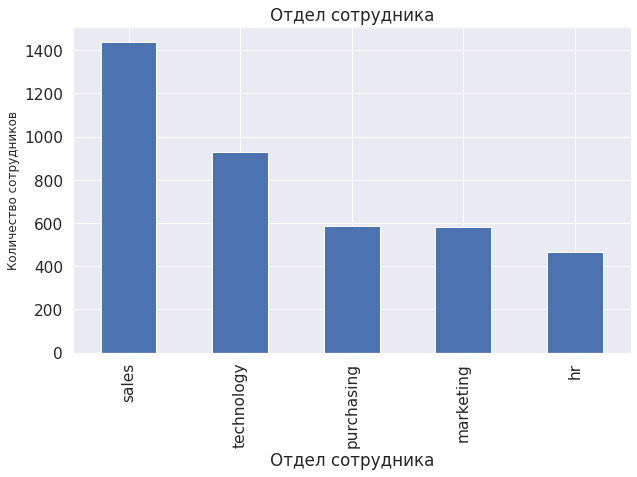

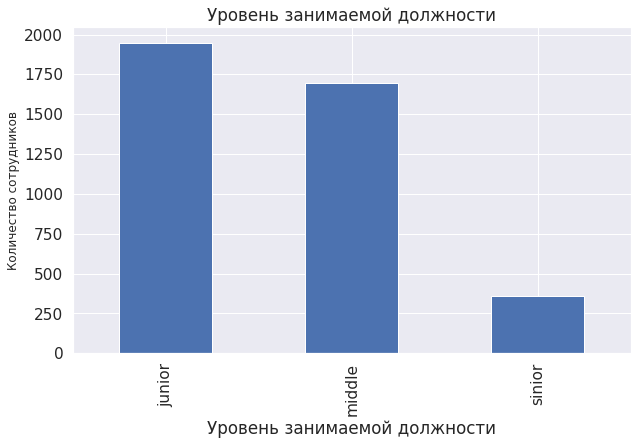

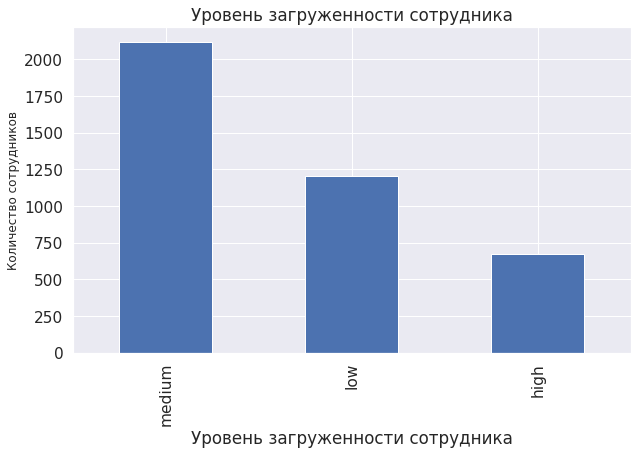

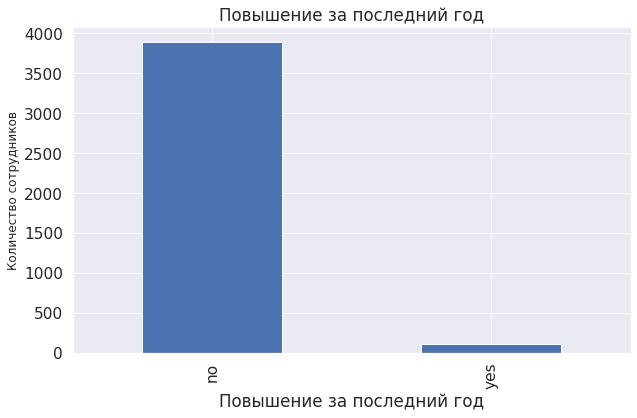

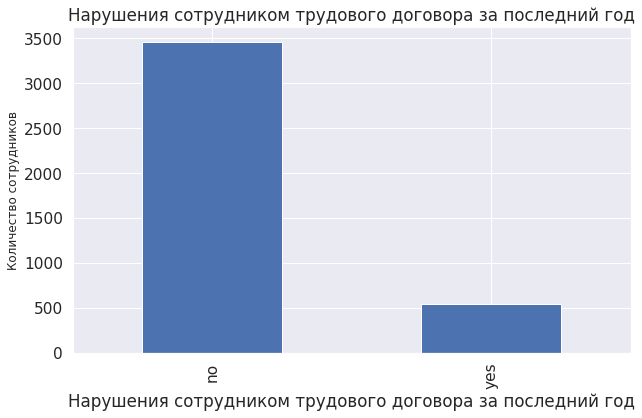

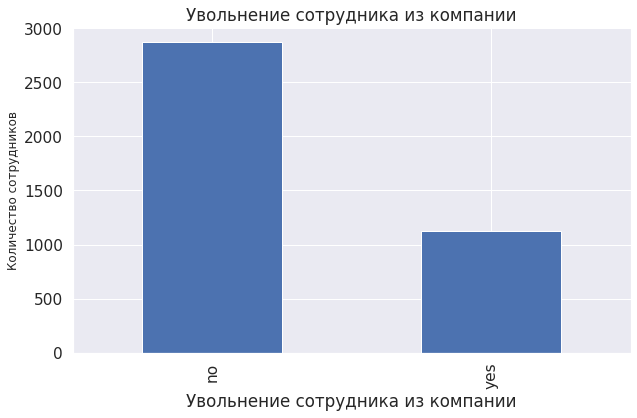

In [42]:
for i in range(len(cat_col_2)):
    plt.figure(figsize=(10, 6))
    train_quit[cat_col_2[i]].value_counts().plot.bar()
    plt.title(titles_cat_col_2[i])
    plt.xlabel(titles_cat_col_2[i]) 
    plt.ylabel('Количество сотрудников', size=12)
    plt.show()

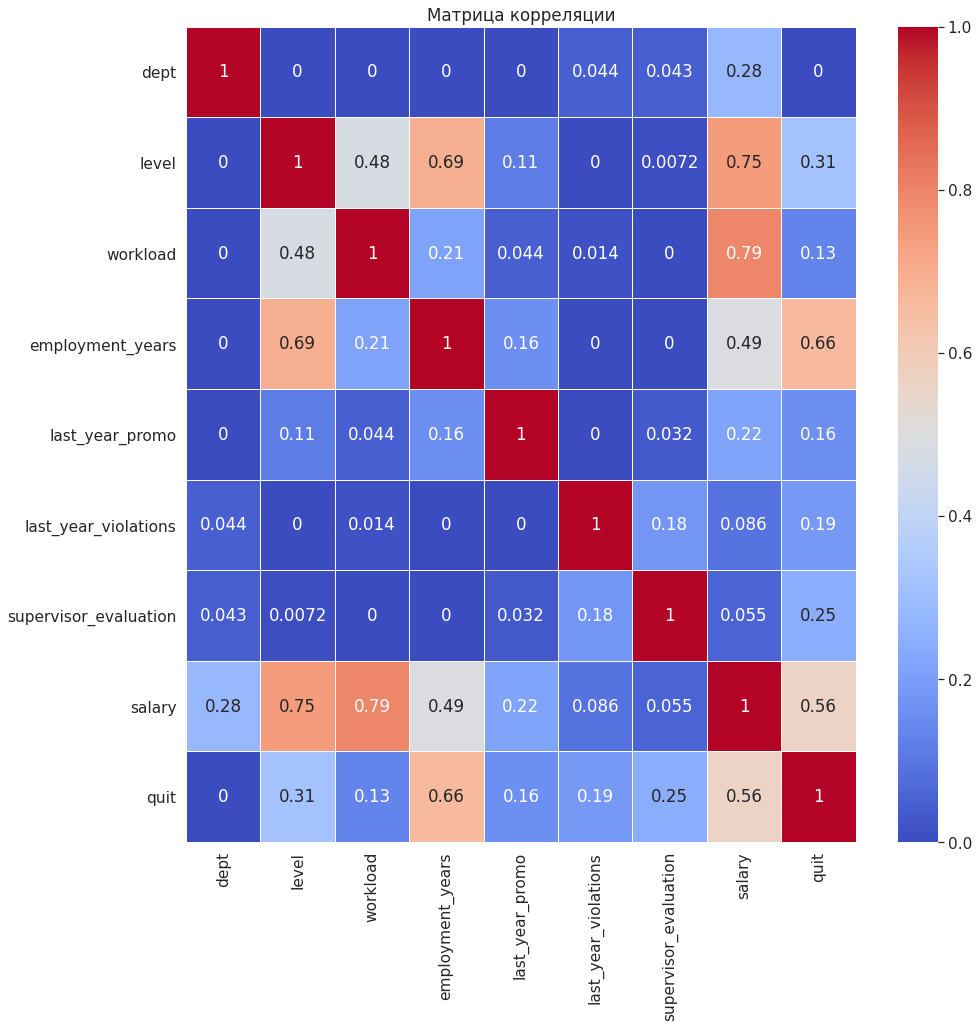

In [43]:
train_quit_1=train_quit.drop(['id'], axis=1)
corr_matrix = train_quit_1.phik_matrix(interval_cols = num_col)
sns.set(font_scale=1.4)
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Исследовательский анализ данных в *train_quit* показал, что между исследуемыми данными и данными с *job_satisfaction* сильной разницы нет. Признак *quit* высоко коррелируется с длительностью работы в компании.

In [44]:
#Разделим на ушедших и оставшихся
tqy=train_quit[train_quit['quit'] == 'yes']
tqy.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


In [45]:
#Список количественных переменных
num=['salary']
#Список с названиями графиков 
titles_num= ['Ежемесячная зарплата сотрудника']

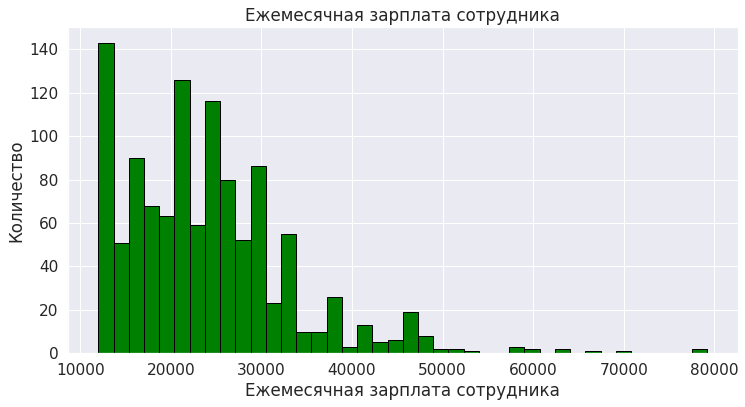

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


In [46]:
#Построим гистограммы и рассмотрим mean,  median, min, max
for i in range(len(num)):
    plt.figure(figsize=(12, 6))
    plt.hist(tqy[num[i]], color = 'green', edgecolor = 'black', bins = 40)
    plt.title(titles_num[i])
    plt.ylabel("Количество")
    plt.xlabel(titles_num[i])
    plt.show()
    print(tqy[num[i]].describe())

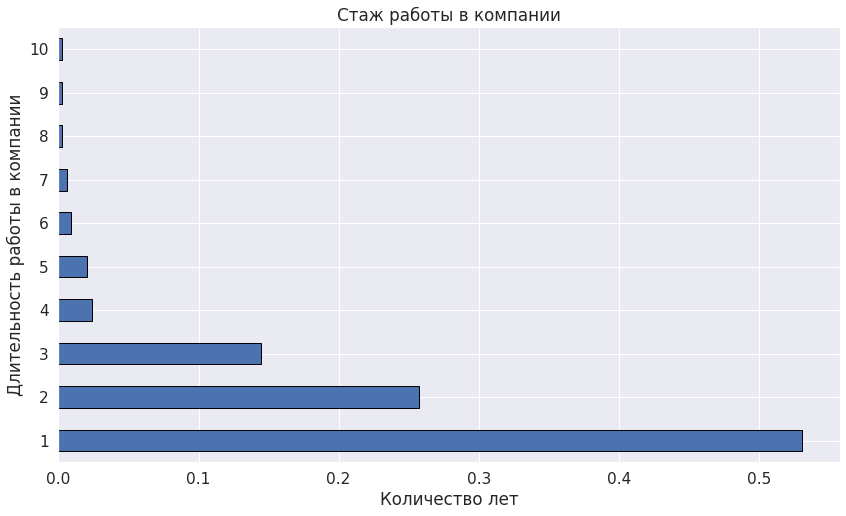

In [47]:
tqy['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Стаж работы в компании')
plt.xlabel('Количество лет')
plt.ylabel('Длительность работы в компании')
plt.show()

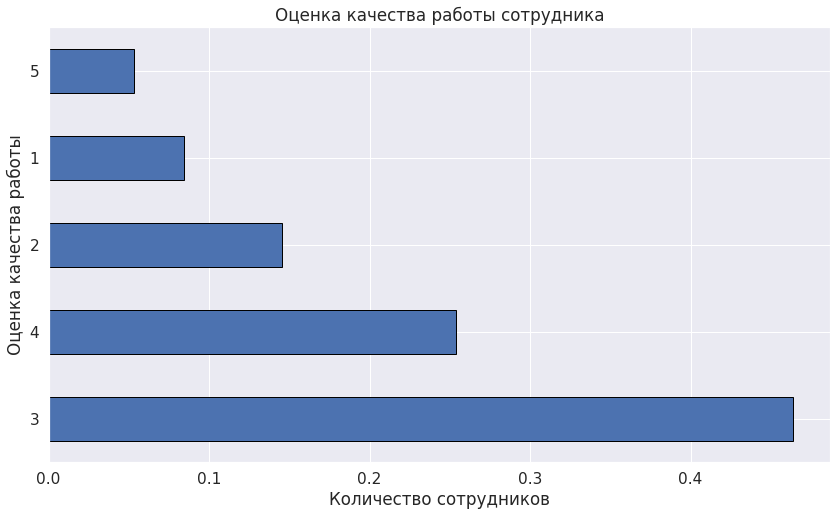

In [48]:
tqy['supervisor_evaluation'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8),  ec ='black', grid=True)
plt.title(f'Оценка качества работы сотрудника')
plt.xlabel('Количество сотрудников')
plt.ylabel('Оценка качества работы')
plt.show()

In [49]:
# создадим список с категориальных перемен
cat=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# создадим список с названиями графиков 
titles_cat= ['Отдел сотрудника', 
             'Уровень занимаемой должности', 
             'Уровень загруженности сотрудника', 
             'Повышение за последний год', 
             'Нарушения сотрудником трудового договора за последний год']

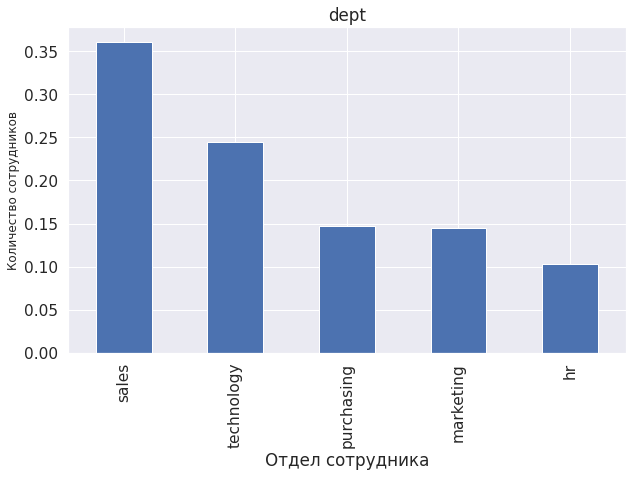

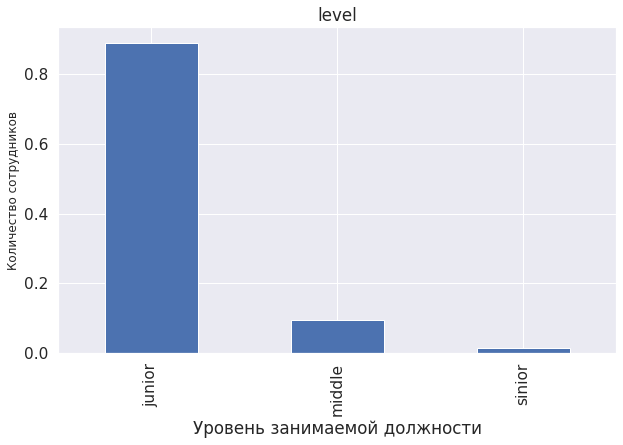

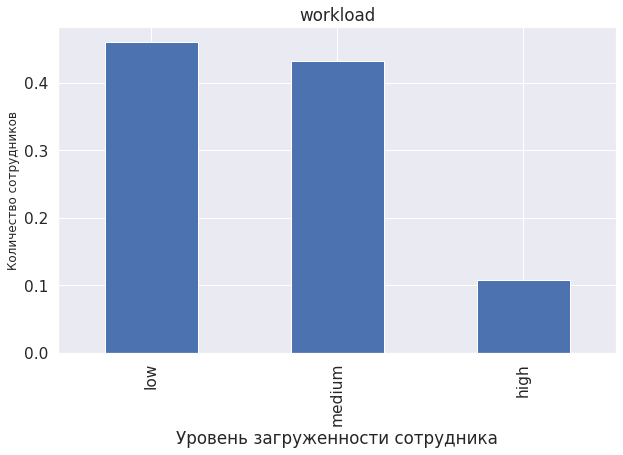

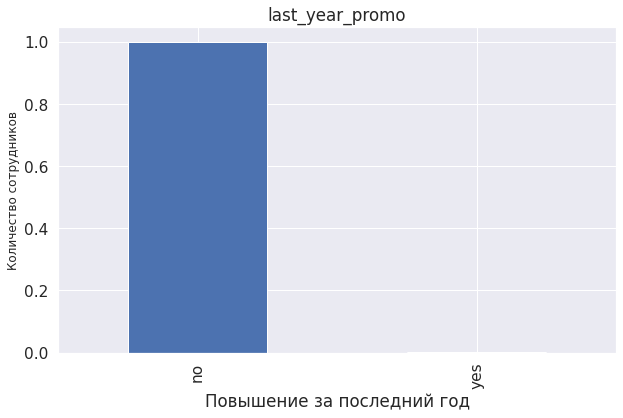

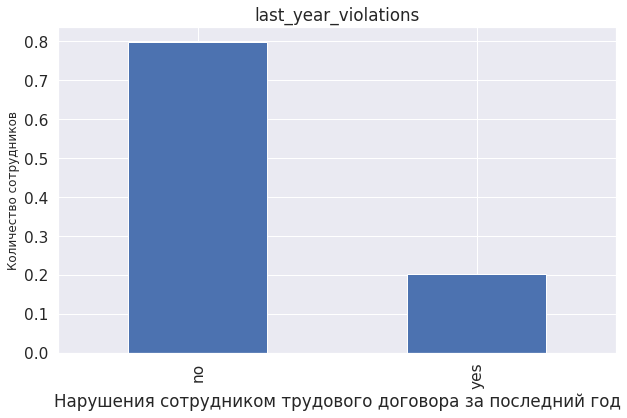

In [50]:
for i in range(len(cat)):
    plt.figure(figsize=(10, 6))
    tqy[cat[i]].value_counts(normalize=True).plot.bar()
    plt.title(cat[i])
    plt.xlabel(titles_cat[i])
    plt.ylabel('Количество сотрудников', size=12)
    plt.show()

In [51]:
category_quit = train_quit.select_dtypes(exclude='number').columns.tolist()
category_quit.extend(['supervisor_evaluation','employment_years'])
category_quit.remove('quit')
category_quit

['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'employment_years']

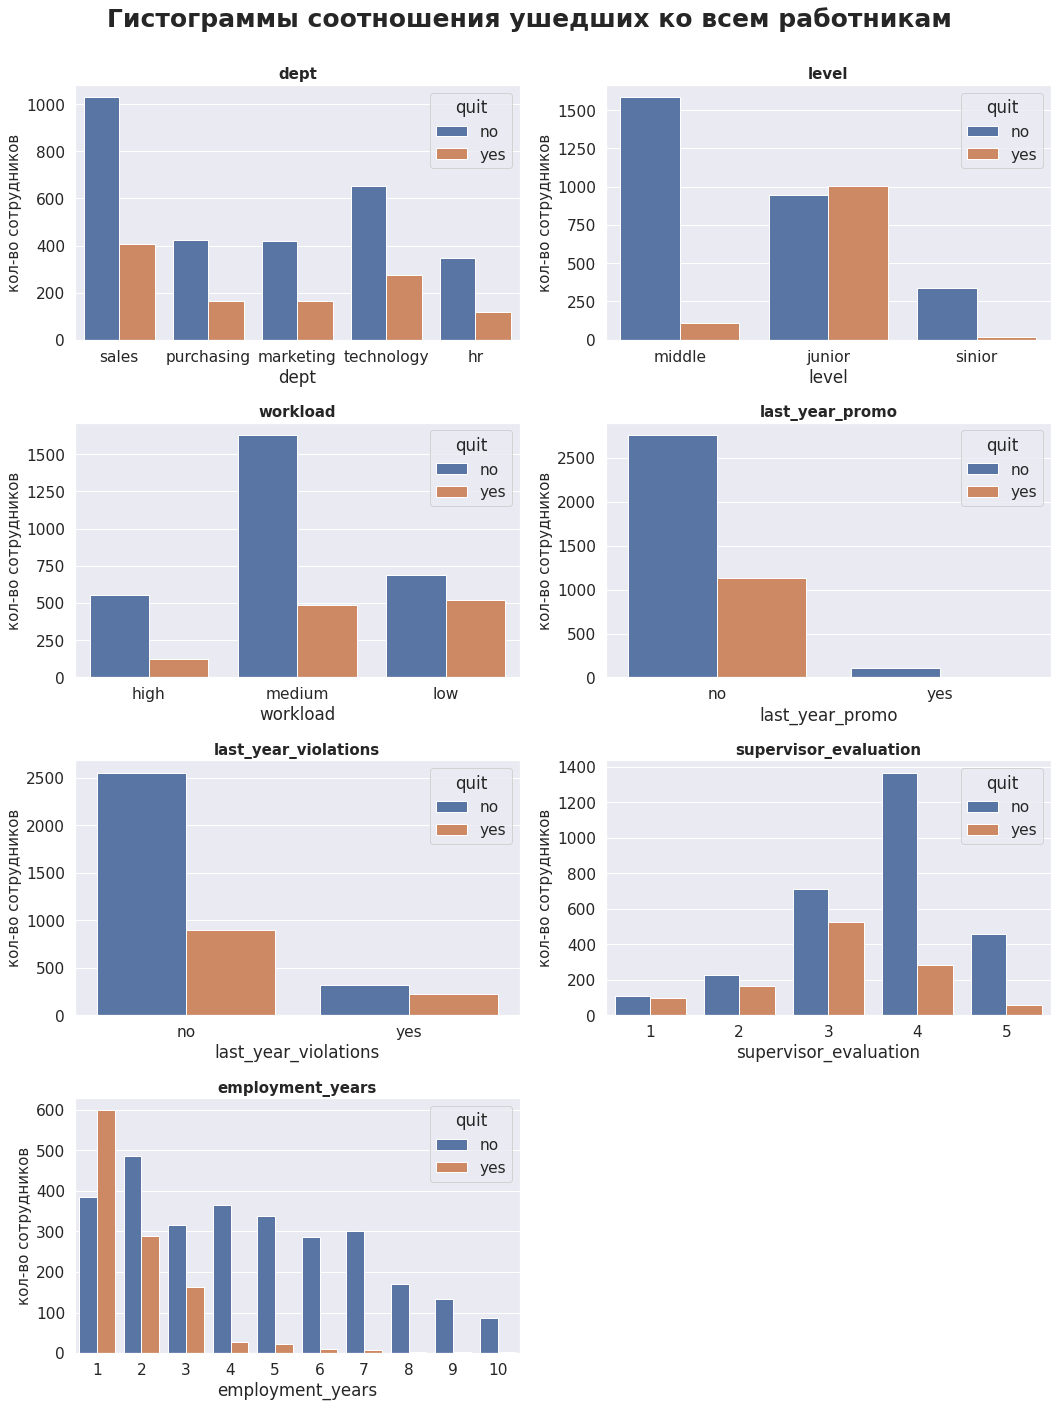

In [52]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,20))
fig.suptitle(f'Гистограммы соотношения ушедших ко всем работникам\n', fontsize = 25, fontweight='bold')

temp = 1
for i in category_quit:
    plt.subplot(4, 2, temp)
    sns.countplot(x = i, data = train_quit, hue = 'quit')
    temp += 1
    plt.title(f'{i}', fontsize = 15, fontweight='bold')
    plt.ylabel('кол-во сотрудников', fontsize = 15)

plt.tight_layout()

In [53]:
display(train_quit.groupby(['dept'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['level'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['workload'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['last_year_promo'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['last_year_violations'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['supervisor_evaluation'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['employment_years'])['quit'].value_counts(normalize=True)*100,
        train_quit.groupby(['salary'])['quit'].value_counts(normalize=True)*100)

dept        quit
hr          no      75.000000
            yes     25.000000
marketing   no      71.993127
            yes     28.006873
purchasing  no      71.768707
            yes     28.231293
sales       no      71.696801
            yes     28.303199
technology  no      70.258621
            yes     29.741379
Name: quit, dtype: float64

level   quit
junior  yes     51.462288
        no      48.537712
middle  no      93.624557
        yes      6.375443
sinior  no      95.238095
        yes      4.761905
Name: quit, dtype: float64

workload  quit
high      no      82.047478
          yes     17.952522
low       no      57.036424
          yes     42.963576
medium    no      76.959396
          yes     23.040604
Name: quit, dtype: float64

last_year_promo  quit
no               no      71.005917
                 yes     28.994083
yes              no      99.115044
                 yes      0.884956
Name: quit, dtype: float64

last_year_violations  quit
no                    no      73.950796
                      yes     26.049204
yes                   no      58.165138
                      yes     41.834862
Name: quit, dtype: float64

supervisor_evaluation  quit
1                      no      52.970297
                       yes     47.029703
2                      no      58.056266
                       yes     41.943734
3                      no      57.583131
                       yes     42.416869
4                      no      82.708585
                       yes     17.291415
5                      no      88.461538
                       yes     11.538462
Name: quit, dtype: float64

employment_years  quit
1                 yes     60.812183
                  no      39.187817
2                 no      62.676963
                  yes     37.323037
3                 no      65.970772
                  yes     34.029228
4                 no      93.129771
                  yes      6.870229
5                 no      93.646409
                  yes      6.353591
6                 no      96.621622
                  yes      3.378378
7                 no      97.727273
                  yes      2.272727
8                 no      98.275862
                  yes      1.724138
9                 no      97.794118
                  yes      2.205882
10                no      96.666667
                  yes      3.333333
Name: quit, dtype: float64

salary  quit
12000   yes      89.814815
        no       10.185185
13200   yes      88.461538
        no       11.538462
14400   yes      89.473684
                   ...    
88800   no      100.000000
91200   no      100.000000
92400   no      100.000000
94800   no      100.000000
96000   no      100.000000
Name: quit, Length: 110, dtype: float64

**Портрет «уволившегося сотрудника:**

- работал в отделе *sales* по количеству сотрудников, а по процентному соотношению в отделе *technology*

- уровень занимаемой должности *junior*

- низкий уровень загруженности

- без повышения за год

- с минимальными нарушениями за год

- с уровнем зарплаты в среднем ниже на примерно 10000 тыс. руб.

- с оценкой качества 3 балла

- с длительностью работы преимущественно год.

In [54]:
#Объеденим датасеты
tt = test_target.merge(test_target_quit, on='id')
tt_yes=tt[tt['quit'] == 'yes']
tt_no=tt[tt['quit'] == 'no']
tt_yes.head(), tt_no.head()

(        id  job_satisfaction_rate quit
 2   418490                   0.60  yes
 4   826430                   0.08  yes
 20  508688                   0.58  yes
 29  343440                   0.35  yes
 30  622918                   0.77  yes,
        id  job_satisfaction_rate quit
 0  130604                   0.74   no
 1  825977                   0.75   no
 3  555320                   0.72   no
 5  817219                   0.76   no
 6  269033                   0.64   no)

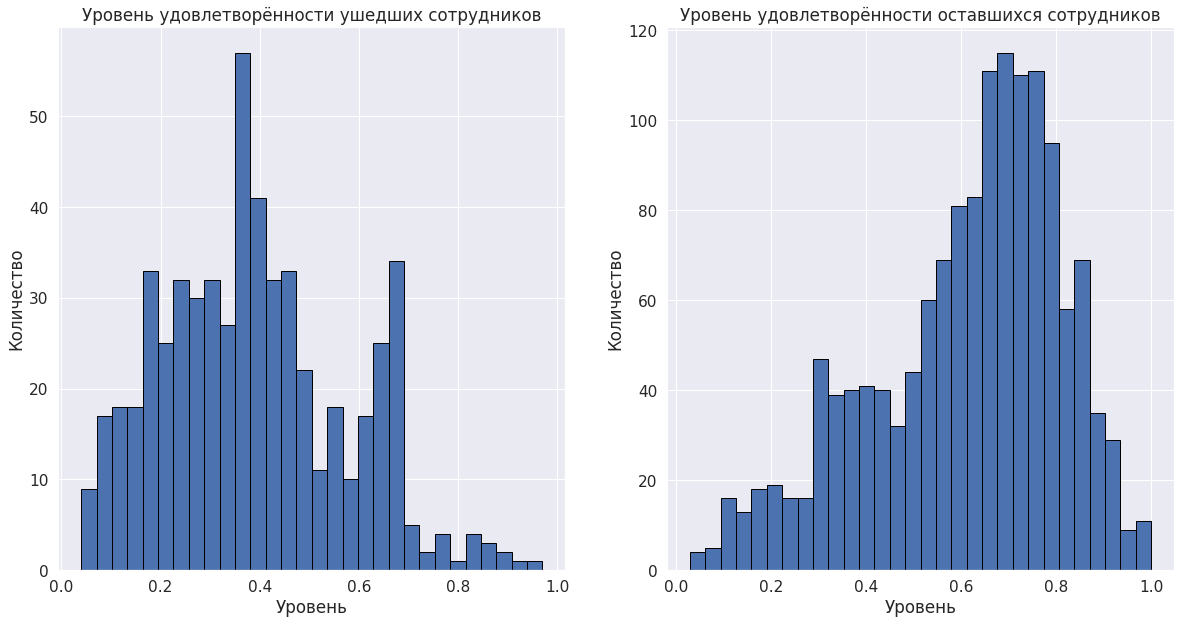

(count    564.000000
 mean       0.387713
 std        0.185784
 min        0.040000
 25%        0.240000
 50%        0.370000
 75%        0.492500
 max        0.970000
 Name: job_satisfaction_rate, dtype: float64,
 count    1436.000000
 mean        0.612040
 std         0.199367
 min         0.030000
 25%         0.500000
 50%         0.660000
 75%         0.760000
 max         1.000000
 Name: job_satisfaction_rate, dtype: float64)

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.hist(tt_yes['job_satisfaction_rate'], bins = 30, ec='black')
ax1.set_title('Уровень удовлетворённости ушедших сотрудников')
ax1.grid(True)
ax1.set_xlabel('Уровень')
ax1.set_ylabel('Количество')

ax2.hist(tt_no['job_satisfaction_rate'], bins = 30,  ec='black')
ax2.set_title('Уровень удовлетворённости оставшихся сотрудников')
ax2.grid(True)
ax2.set_xlabel('Уровень')
ax2.set_ylabel('Количество')

plt.show()
tt_yes['job_satisfaction_rate'].describe(), tt_no['job_satisfaction_rate'].describe()

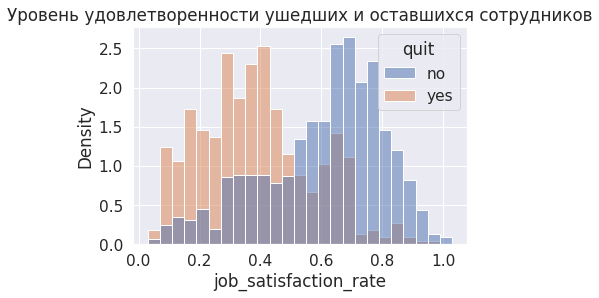

In [56]:
sns.histplot(data=tt, 
             x="job_satisfaction_rate", 
             binwidth=0.04, 
             hue="quit", 
             stat='density', 
             common_norm=False).set(title='Уровень удовлетворенности ушедших и оставшихся сотрудников')
plt.show()

Желание уволиться зависит от уровня удовлетворенности сотрудника. Средняя оценка для ушедших работников = 0.387713, для оставшихся = 0.612040.

**Вывод по исследовательскому анализу данных:**

Исследовательский анализ данных в *train_quit* показал, что между исследуемыми данными и данными с *job_satisfaction* сильной разницы нет. Признак *quit* высоко коррелируется с длительностью работы в компании.

**Был составлен портрет «уволившегося сотрудника:**

- работал в отделе *sales*

- уровень занимаемой должности *junior*

- низкий уровень загруженности

- без повышения за год

- с минимальными нарушениями за год

- с уровнем зарплаты в среднем ниже на примерно 10000 тыс. руб.

- с оценкой качества 3 балла

- с длительностью работы преимущественно год.

Также подтвердили утверждене аналитиков, что желание уволиться зависит от уровня удовлетворенности сотрудника. Средняя оценка для ушедших работников -0.387713, для оставшихся - 0.612040.

### ДОБАВЛЕНИЕ НОВОГО ВХОДНОГО ПРИЗНАКА

In [57]:
train_quit['job_satisfaction_rate'] = r_search.best_estimator_.predict(train_quit.drop(['quit'], axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.637273
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [58]:
test_features['job_satisfaction_rate'] = r_search.best_estimator_.predict(test_features)
test_features.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.652000
3,418655,sales,middle,low,6,no,no,4,19200,0.666000
4,789145,hr,middle,medium,5,no,no,5,40800,0.825556


**Вывод по добавлению нового входного признака:** добавили *job_satisfaction_rate* к тренировочным и тестовым данным второй задачи.

### ПОДГОТОВКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛЕЙ

In [59]:
#Сделаем id индексом, проверка на дубликаты
train_quit = train_quit.set_index('id')
print('Количество явных дубликатов в датафрейте:', train_quit.duplicated().sum())

Количество явных дубликатов в датафрейте: 1413


In [61]:
X_train_2 = train_quit.drop(['quit'], axis=1)
y_train_2 = train_quit['quit']

X_train_2.shape

(4000, 9)

In [62]:
#Объеденим датасеты X_test_2 и y_test_2
test_2 = test_features.merge(test_target_quit, on='id')

# снова разделим на X_test_2 и y_test_2
X_test_2 = test_2.drop(['id', 'quit'], axis=1)
y_test_2 = test_2['quit']

X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.885000
1,hr,junior,medium,1,no,no,4,30000,0.682222
2,sales,middle,low,5,no,no,4,19200,0.652000
3,sales,middle,low,6,no,no,4,19200,0.666000
4,hr,middle,medium,5,no,no,5,40800,0.825556


*dept, last_year_promo, last_year_violations* будем кодировать OneHotEncoder.

*level, workload* - OrdinalEncoder.

*employment_years, supervisor_evaluation, salary, job_satisfaction_rate* масштабируем.

In [63]:
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

ohe_columns_2 = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [64]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_2),
        ('ord', ord_pipe, ord_columns_2),
        ('num', MinMaxScaler(), num_columns_2)], 
    remainder='passthrough')

pipeline_final = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__max_features': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # словарь для модели CVС()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__kernel': ['linear', 'rbf']}]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)
randomized_search.fit(X_train_2, y_train_2)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [65]:
results_dataframe = pd.DataFrame(randomized_search.cv_results_)
display(results_dataframe)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022701,0.000736,0.009022,0.000194,StandardScaler(),11.0,7.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'models__max_features': 11, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}",0.913347,0.916758,0.912078,0.907571,0.934156,0.916782,0.009172,4
1,0.018823,0.000252,0.008187,0.000190,passthrough,6.0,5.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}",0.907822,0.926594,0.923048,0.913616,0.925812,0.919379,0.007398,2
2,0.019414,0.000308,0.008036,0.000177,passthrough,12.0,5.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__max_features': 12, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}",0.918517,0.919826,0.924202,0.924659,0.923127,0.922066,0.002451,1
3,0.020681,0.000156,0.008774,0.000207,MinMaxScaler(),5.0,8.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}",0.902178,0.918299,0.917915,0.908371,0.927420,0.914837,0.008739,5
4,0.020048,0.000490,0.009332,0.000305,StandardScaler(),4.0,4.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}",0.886053,0.902270,0.893884,0.891059,0.905130,0.895679,0.007071,7
5,0.022899,0.000223,0.009010,0.000208,MinMaxScaler(),10.0,11.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 10, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=42)}",0.886377,0.909443,0.911383,0.883981,0.916841,0.901605,0.013650,6
6,0.021059,0.001406,0.009208,0.000728,StandardScaler(),4.0,2.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}",0.838915,0.858494,0.864593,0.842492,0.873907,0.855680,0.013226,10
7,0.019200,0.000293,0.007917,0.000210,passthrough,4.0,14.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__max_features': 4, 'models__max_depth': 14, 'models': DecisionTreeClassifier(random_state=42)}",0.886792,0.895791,0.887442,0.874074,0.911079,0.891036,0.012190,8
8,0.157474,0.060865,0.009808,0.000471,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",1.0,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}",0.922793,0.913622,0.914367,0.910696,0.927521,0.917800,0.006311,3
9,0.050299,0.059182,0.008616,0.000121,MinMaxScaler(),7.0,3.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}",0.878445,0.883834,0.876658,0.879753,0.888556,0.881449,0.004267,9


In [66]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [67]:
y_test_proba_2 = randomized_search.predict_proba(X_test_2)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_test_proba_2)}')

Метрика ROC-AUC на тестовой выборке: 0.92021647010016


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Вывод по подготовке данных и обучению моделей:**

Лучшей моделью оказалась:

DecisionTreeClassifier(max_depth=5, max_features=12, random_state=42)

Метрика лучшей модели на тренировочной выборке: 0.9220659879986801

Метрика ROC-AUC на тестовой выборке: 0.92021647010016

## ОБЩИЕ ВЫВОДЫ

### В целях проекта стояла задача построить 2 модели, а именно:

1. модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

2. модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Нам были предоставлены следующие датасеты:

- для первой задачи: 
Тренировочная выборка: train_job_satisfaction_rate.csv, входные признаки тестовой выборки: test_features.csv, целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv.

- для второй задачи: 
Тренировочная выборка: train_quit.csv, входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv, целевой признак тестовой выборки: test_target_quit.csv.

### **Выводы по первой задаче:**

#### Предобработка данных: в целом данные были в норме.


#### Исследовательский анализ данных: 

- в основном трудятся в компании от 1 до 6 лет. В среднем рабочей стаж 3 года. 

- больше всего оценок качества работы сотрудников приходятся на 3 и 4 балла. Есть и те у кого оценка 1.

- средняя зарплата не намного больше медианной, при учете нескольких выбросов, и равна 33926,70 тыс. руб. Максимальная 98400 тыс. руб., а минимальная — 12000 тыс. руб. Удовлетворенность сотрудника работой соответствует оценке качества.

- преимущественное количество сотрудников работают в отделе sales, за ними следуют отдел technology.

- по уровню занимаемой должности, основное число сотрудников это junior, а за ним не отстает middle;

- по загруженности персонала видим что в основном это средний уровень, много и низко загруженных сотрудников;

- в компании за последний год почти не было повышения, вероятно из-за среднего стажа в 3 года;

- по нарушениям отметим низкий уровень нарушений трудового договора, но не без греха.

По корреляционному анализу - мультиколлинеарности не наблюдается. Высокие уровни зависимости между: зарплатой и уровнем занимаемой должности, зарплатой и уровнем загруженности, оценкой качества работы сотрудника и уровнем удовлетворенности сотрудника работой.

#### Подготовка данных и обучение моделей:

Для поиска лучшей модели:

- была проведена подготовка данных;

- в качестве моделей рассматривались DecisionTreeRegressor() и LinearRegression();

- для модели DecisionTreeRegressor был подобраны гиперпараметры;

- для перебора моделей и параметров использовали метод RandomizedSearchCV;

- в качестве метрики оценки модели была определена метрика smape.
    
Лучшей моделью оказалась:

- DecisionTreeRegressor(max_depth=17, max_features=12, random_state=42)

- Метрика лучшей модели на тренировочной выборке: 15.2

- Значение метрики SMAPE на тестовых данных: 13.67.    

### **Выводы по второй задаче:**

#### Предобработка данных: в целом данные были в норме.

#### Исследовательский анализ данных:

Исследовательский анализ данных в *train_quit* показал, что между исследуемыми данными и данными с *job_satisfaction* сильной разницы нет. 

По корреляционному анализу - мультиколлинеарности не наблюдается. Признак *quit* высоко коррелируется с длительностью работы в компании.

#### Добавили job_satisfaction_rate к тренировочным и тестовым данным второй задачи.

#### Подготовка данных и обучение моделей:

Лучшей моделью оказалась:


- DecisionTreeClassifier(max_depth=5, max_features=12, random_state=42)

- Метрика лучшей модели на тренировочной выборке: 0.9220659879986801

- Метрика ROC-AUC на тестовой выборке: 0.92021647010016

### Рекомендации:

Разработка плана карьерного роста. Необходима четкая инструкция для перехода от уровня к уровню.

Подумать о возможности премирования на основе стажа проведенного в компании.

Эффективное распределение задач в отделах.